In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

DATA_FILE = 'CWRU_preprocessed_labeled.csv'
TARGET = 'Fault type'
NUMERICAL_FEATURES = ['Standard deviation', 'Mean', 'Variance', 'Peak-to-peak factor', 'RMS', 'Crest factor', 'Kurtosis']

Load data.

In [6]:
labeled_data = pd.read_csv(DATA_FILE)

Build pipeline for preprocessing and training. 

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

imputer_numerical = SimpleImputer(strategy='median')
std_scaler = StandardScaler()
pipe_numerical = Pipeline([('imputer', imputer_numerical),
                           ('scaler', std_scaler)])

# Using TargetEncoder for the target variable
target_encoder = TargetEncoder(target_type='multiclass', shuffle=True, random_state=42)
pipe_categorical = Pipeline([('encoder', target_encoder)])

# Create ColumnTransformer
col_transformer = ColumnTransformer([
    ('num_preproc', pipe_numerical, NUMERICAL_FEATURES),
    ('cat_preproc', pipe_categorical, [0])
])

Train and evaluate SVM classifier. 

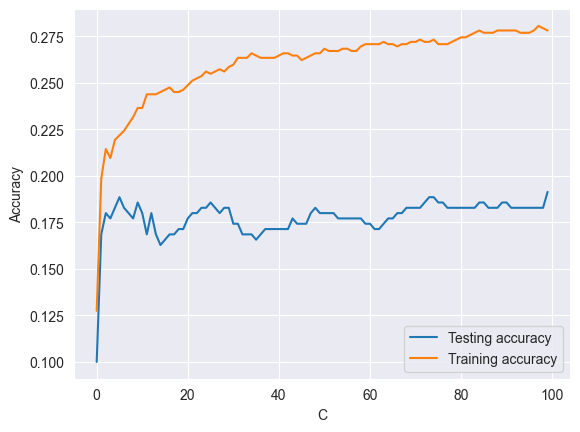

Optimal C: 99
Max test accuracy: 0.19142857142857142


In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

x = labeled_data.drop([TARGET], axis=1)
y = labeled_data[TARGET]
y = y.to_frame(name=TARGET)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

c_svm = np.arange(0.01, 100)
train_accuracy = np.empty(len(c_svm))  # arrays to store training and test accuracies
test_accuracy = np.empty(len(c_svm))

for i, k in enumerate(c_svm):
    model = SVC(C=k)
    pipe_final = Pipeline([('preproc', col_transformer),
                           ('model', model)])
    pipe_final.fit(x_train, y_train.values.ravel())
    train_accuracy[i] = pipe_final.score(x_train, y_train)
    test_accuracy[i] = pipe_final.score(x_test, y_test)
    cm = confusion_matrix(y_test, pipe_final.predict(x_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=pipe_final.classes_)
    # disp.plot()

plt.plot(c_svm, test_accuracy, label='Testing accuracy')
plt.plot(c_svm, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

print(f"Optimal C: {np.argmax(test_accuracy)}")  # print optimal C and max test accuracy
print(f"Max test accuracy: {max(test_accuracy)}")